# HuBERT-ECG Feature Analysis Notebook

This notebook provides an interactive interface for analyzing HuBERT-ECG inference results.
It demonstrates how to interpret the extracted features and use them for downstream tasks.

## Overview

After running `make inference`, you get:
- **Feature files**: 768-dimensional representations for each time step
- **Metadata**: Information about the inference process
- **Analysis tools**: Scripts to interpret and visualize the results

This notebook walks you through:
1. Loading and examining your inference results
2. Understanding the feature structure
3. Analyzing temporal patterns
4. Comparing patients
5. Setting up classification tasks

## Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add scripts directory to path
sys.path.append('../scripts')

# Import our analysis modules
from analyze_features import HuBERTFeatureAnalyzer
from visualize_results import HuBERTFeatureVisualizer
from classification_pipeline import HuBERTClassificationPipeline

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Setup complete!")

Setup complete!


## 1. Load and Examine Inference Results

First, let's load the results from your `make inference` command and see what we have.

In [2]:
# Set paths
results_dir = '../results'
analysis_output_dir = '../analysis_output'
viz_output_dir = '../visualization_output'

# Load the inference results metadata
results_csv = os.path.join(results_dir, 'inference_results.csv')

if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print(f"Found inference results for {len(df)} files")
    print(f"Successful inferences: {len(df[df['status'] == 'success'])}")
    print("\nResults overview:")
    display(df)
else:
    print(f"No results found at {results_csv}")
    print("Please run 'make inference' first to generate results.")

Found inference results for 3 files
Successful inferences: 3

Results overview:


,patient,filename,original_shape,preprocessed_shape,features_shape,features_file,status
0,PATIENTA,9C687DB1.npy,"(12, 5000)","torch.Size([1, 12000])","(1, 187, 768)",PATIENTA/9C687DB1_features.npy,success
1,PATIENTB,75C6B3C1.npy,"(12, 5000)","torch.Size([1, 12000])","(1, 187, 768)",PATIENTB/75C6B3C1_features.npy,success
2,PATIENTC,93C7C5AD.npy,"(12, 5000)","torch.Size([1, 12000])","(1, 187, 768)",PATIENTC/93C7C5AD_features.npy,success


## 2. Understanding the Feature Structure

Let's examine what the HuBERT-ECG model extracted from your ECG data.

Sample patient: PATIENTA
Original ECG shape: (12, 5000)
Preprocessed shape: torch.Size([1, 12000])
Features shape: (1, 187, 768)

Feature interpretation:
  - Time steps: 187 (temporal sequence)
  - Feature dimensions: 768 (learned cardiac representations)
  - Total features per patient: 143,616

Feature statistics:
  - Mean: 0.000648
  - Std: 0.896790
  - Range: [-3.706863, 3.616734]
  - Non-zero ratio: 1.0000


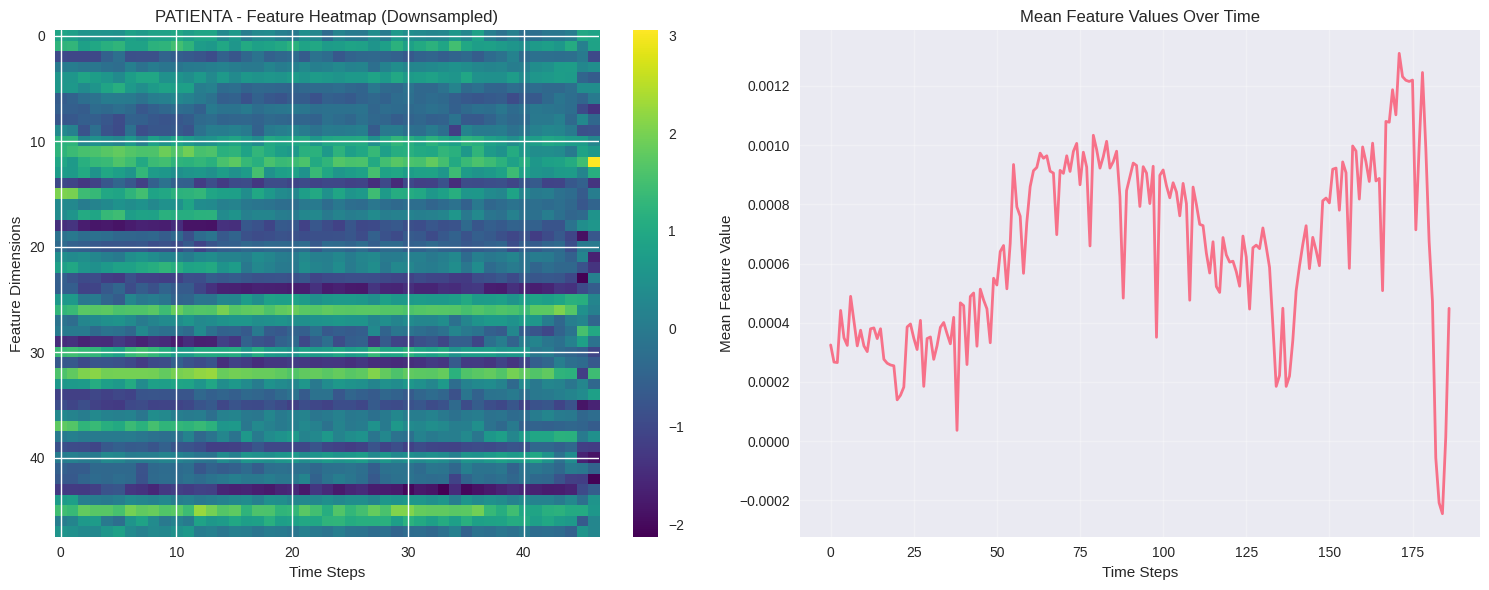

In [3]:
# Load a sample feature file to understand the structure
if 'df' in locals() and len(df) > 0:
    # Get the first successful result
    successful_results = df[df['status'] == 'success']
    if len(successful_results) > 0:
        sample_row = successful_results.iloc[0]
        sample_patient = sample_row['patient']
        sample_features_file = sample_row['features_file']
        
        # Load the features
        features_path = os.path.join(results_dir, sample_features_file)
        features = np.load(features_path)
        
        print(f"Sample patient: {sample_patient}")
        print(f"Original ECG shape: {sample_row['original_shape']}")
        print(f"Preprocessed shape: {sample_row['preprocessed_shape']}")
        print(f"Features shape: {features.shape}")
        print(f"\nFeature interpretation:")
        
        if features.ndim == 3 and features.shape[0] == 1:
            features_2d = features.squeeze(0)  # Remove batch dimension
            print(f"  - Time steps: {features_2d.shape[0]} (temporal sequence)")
            print(f"  - Feature dimensions: {features_2d.shape[1]} (learned cardiac representations)")
            print(f"  - Total features per patient: {features_2d.shape[0] * features_2d.shape[1]:,}")
            
            # Show basic statistics
            print(f"\nFeature statistics:")
            print(f"  - Mean: {np.mean(features_2d):.6f}")
            print(f"  - Std: {np.std(features_2d):.6f}")
            print(f"  - Range: [{np.min(features_2d):.6f}, {np.max(features_2d):.6f}]")
            print(f"  - Non-zero ratio: {np.mean(features_2d != 0):.4f}")
        
        # Quick visualization
        plt.figure(figsize=(15, 6))
        
        # Plot 1: Feature heatmap (downsampled for visibility)
        plt.subplot(1, 2, 1)
        if features.ndim == 3:
            features_2d = features.squeeze(0)
        downsampled = features_2d[::4, ::16]  # Every 4th time step, every 16th feature
        plt.imshow(downsampled.T, aspect='auto', cmap='viridis')
        plt.title(f'{sample_patient} - Feature Heatmap (Downsampled)')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Dimensions')
        plt.colorbar()
        
        # Plot 2: Temporal evolution of mean features
        plt.subplot(1, 2, 2)
        mean_features = np.mean(features_2d, axis=1)
        plt.plot(mean_features, linewidth=2)
        plt.title('Mean Feature Values Over Time')
        plt.xlabel('Time Steps')
        plt.ylabel('Mean Feature Value')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("No successful inference results found.")
else:
    print("No inference results loaded. Please run the previous cell first.")

## 3. Run Analysis Scripts

Now let's run our comprehensive analysis scripts to get detailed insights.

In [4]:
# Run the feature analysis script
print("Running feature analysis...")
analyzer = HuBERTFeatureAnalyzer(results_dir, analysis_output_dir)
analysis_results = analyzer.run_complete_analysis()

Running feature analysis...
Starting comprehensive HuBERT-ECG feature analysis...
Loading HuBERT-ECG inference results...
Found 3 successful inference results
  Loaded PATIENTA: (1, 187, 768)
  Loaded PATIENTB: (1, 187, 768)
  Loaded PATIENTC: (1, 187, 768)
Successfully loaded features for 3 patients

Analyzing basic feature statistics...
Basic statistics saved to: ../analysis_output/feature_statistics.csv

Feature Statistics Summary:
PATIENTA:
  Shape: (187, 768)
  Mean: 0.000648, Std: 0.896790
  Range: [-3.706863, 3.616734]
  Zero ratio: 0.0000

PATIENTB:
  Shape: (187, 768)
  Mean: 0.000675, Std: 0.897113
  Range: [-3.341562, 4.004590]
  Zero ratio: 0.0000

PATIENTC:
  Shape: (187, 768)
  Mean: 0.000610, Std: 0.896585
  Range: [-2.987008, 3.537015]
  Zero ratio: 0.0000

Analyzing temporal patterns...
Temporal analysis plot saved to: ../analysis_output/temporal_analysis.png
Temporal patterns data saved to: ../analysis_output/temporal_patterns.csv
Analyzing feature distributions...
Di

In [5]:
# Run the visualization script
print("Creating visualizations...")
visualizer = HuBERTFeatureVisualizer(results_dir, viz_output_dir)
visualizer.run_complete_visualization()

Creating visualizations...
Starting comprehensive HuBERT-ECG feature visualization...
Loading HuBERT-ECG inference results for visualization...
Found 3 successful inference results
  Loaded PATIENTA: (1, 187, 768)
  Loaded PATIENTB: (1, 187, 768)
  Loaded PATIENTC: (1, 187, 768)
Successfully loaded features for 3 patients
Creating feature heatmaps...
Feature heatmaps saved to: ../visualization_output/feature_heatmaps.png
Creating temporal evolution plots...
Temporal evolution plots saved to: ../visualization_output/temporal_evolution.png
Creating feature importance plots...
Feature importance plots saved to: ../visualization_output/feature_importance.png
Creating top features summary...
Top features summary saved to: ../visualization_output/top_features_summary.csv
Top features visualization saved to: ../visualization_output/top_features_visualization.png
Creating detailed patient comparisons...
Detailed patient comparison saved to: ../visualization_output/detailed_patient_comparison.p

In [6]:
# Run the classification pipeline
print("Running classification pipeline...")
classifier = HuBERTClassificationPipeline(results_dir, '../classification_output')
classification_results, feature_importance = classifier.run_complete_pipeline()

Running classification pipeline...
Starting HuBERT-ECG classification pipeline...
Loading HuBERT-ECG features for classification...
Found 3 successful inference results
  Loaded PATIENTA: (1, 187, 768)
  Loaded PATIENTB: (1, 187, 768)
  Loaded PATIENTC: (1, 187, 768)
Successfully loaded features for 3 patients
No labels file provided. Creating synthetic labels for demonstration...
Created synthetic labels for 3 patients:
diagnosis
Abnormal    2
Normal      1
Name: count, dtype: int64
Synthetic labels saved to: ../classification_output/synthetic_labels.csv

Running classification experiments for target: diagnosis
Preparing feature matrix using mean aggregation...
Found 3 patients with both features and labels
Feature matrix shape: (3, 768)
Number of patients: 3
Target distribution:
  Abnormal: 2 (66.7%)
  Normal: 1 (33.3%)
Error during classification pipeline: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less th

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## 4. Summary and Interpretation

Let's summarize what we've learned from your HuBERT-ECG features.

In [ ]:
# Generate a comprehensive summary
print("HuBERT-ECG Feature Analysis Summary")
print("=" * 50)

# Load and display key results
stats_file = os.path.join(analysis_output_dir, 'feature_statistics.csv')
if os.path.exists(stats_file):
    stats_df = pd.read_csv(stats_file)
    print(f"\n📊 Feature Statistics:")
    display(stats_df)

similarity_file = os.path.join(analysis_output_dir, 'patient_similarities.csv')
if os.path.exists(similarity_file):
    similarity_df = pd.read_csv(similarity_file)
    print(f"\n🔗 Patient Similarities:")
    display(similarity_df)

if 'classification_results' in locals():
    print(f"\n🎯 Classification Results:")
    for name, result in classification_results.items():
        if result is not None:
            print(f"  {name}: Accuracy={result['accuracy']:.3f}, F1={result['f1_score']:.3f}")

print(f"\n🚀 Next Steps:")
print(f"  1. Examine visualizations in '{viz_output_dir}'")
print(f"  2. Review analysis results in '{analysis_output_dir}'")
print(f"  3. Use real clinical labels for meaningful classification")
print(f"  4. Explore temporal patterns for rhythm analysis")
print(f"  5. Apply clustering for patient stratification")
print(f"  6. Correlate features with clinical outcomes")